## Vectorized Problem Formulation

In [3]:
import numpy as np
from util_power_flow import create_admittance_matrices
import pdb

import cvxpy as cp

# -----------------------------------------------------------------------------------
#                             Define prob data
# -----------------------------------------------------------------------------------
N = 9
p_min = np.zeros(N)
p_max = np.zeros(N)
q_min = np.zeros(N)
q_max = np.zeros(N)
p_min[[0, 1, 2]] = [10, 10, 10]
p_max[[0, 1, 2]] = [250, 300, 270]
q_min[[0, 1, 2]] = [-5, -5, -5]
p_min[[4,6,8]] = p_max[[4,6,8]] = [-54, -60, -75]
q_min[[4,6,8]] = q_max[[4,6,8]] = [-18, -21, -30]
v_min, v_max = 0.9, 1.1
G0, B0, G_sh, B_sh = create_admittance_matrices()
G = G0 + G_sh
B = B0 + B_sh

# -----------------------------------------------------------------------------------
#                         Define optimization prob
# -----------------------------------------------------------------------------------
theta, P, Q = cp.Variable((N, 1)), cp.Variable((N, N)), cp.Variable((N, N))
v = cp.Variable((N, 1), bounds=[v_min, v_max])
p = cp.Variable(N, bounds=[p_min, p_max])
q = cp.Variable(N, bounds=[q_min, q_max])
C, S = cp.cos(theta - theta.T), cp.sin(theta - theta.T) 

constr = [theta[0] == 0,  p == cp.sum(P, axis=1), q == cp.sum(Q, axis=1),
          P == cp.multiply(v @ v.T, cp.multiply(G, C) + cp.multiply(B, S)),
          Q == cp.multiply(v @ v.T, cp.multiply(G, S) - cp.multiply(B, C))]
cost = (0.11 * p[0]**2 + 5 * p[0] + 150 + 0.085 * p[1]**2 + 1.2 * p[1] + 600 +
        0.1225 * p[2]**2 + p[2] + 335)
prob = cp.Problem(cp.Minimize(cost), constr)

# -----------------------------------------------------------------------------------
#              Solve prob (initialize to 1.0 p.u. and 0 degrees)
# -----------------------------------------------------------------------------------
v.value = np.ones((N, 1))  # TODO: look up why this matters. v is auto-initialized to 1, right? 
                           # Perhaps the order changes of value propagation changes?
theta.value = np.zeros((N, 1)) # Why does this matter? Don't we auto-initialize to zero?
result = prob.solve(solver=cp.IPOPT, verbose=True, nlp=True, derivative_test='none', least_square_init_duals='no')

print(f"\nSolver status: {prob.status}")
print(f"Optimal objective value: {prob.value:.2f}")
print("\nGeneration (MW):")
for i in range(3):
    print(f"  Bus {i+1}: P={p.value[i]:.2f}, Q={q.value[i]:.2f}")

print("\nVoltage magnitudes (p.u.):")
for i in range(N):
    print(f"  Bus {i+1}: {v.value[i, 0]:.4f}")
#
print("\nVoltage angles (degrees):")
for i in range(N):
    print(f"  Bus {i+1}: {np.rad2deg(theta.value[i, 0]):.2f}")

flow_P = cp.multiply(v ** 2, G).value - P.value
flow_G = cp.multiply(v ** 2, B).value - Q.value

(CVXPY) Dec 05 09:49:30 AM: Your problem has 198 variables, 181 constraints, and 0 parameters.
(CVXPY) Dec 05 09:49:30 AM: It is compliant with the following grammars: 
(CVXPY) Dec 05 09:49:30 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 05 09:49:30 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 05 09:49:30 AM: Your problem is compiled with the CPP canonicalization backend.


                                     CVXPY                                     
                             v1.8.0.dev0+0.3215a68                             
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2605
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      651

Total number of variables............................:      855
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:      850
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

## Sparse problem formulation

In [5]:
import numpy as np
from util_power_flow import create_admittance_matrices
import pdb

import cvxpy as cp

# -----------------------------------------------------------------------------------
#                             Define prob data
# -----------------------------------------------------------------------------------
N = 9
p_min = np.zeros(N)
p_max = np.zeros(N)
q_min = np.zeros(N)
q_max = np.zeros(N)
p_min[[0, 1, 2]] = [10, 10, 10]
p_max[[0, 1, 2]] = [250, 300, 270]
q_min[[0, 1, 2]] = [-5, -5, -5]
p_min[[4,6,8]] = p_max[[4,6,8]] = [-54, -60, -75]
q_min[[4,6,8]] = q_max[[4,6,8]] = [-18, -21, -30]
v_min, v_max = 0.9, 1.1
G0, B0, G_sh, B_sh = create_admittance_matrices()
G = G0 + G_sh
B = B0 + B_sh

# -----------------------------------------------------------------------------------
#                         Define optimization prob
# -----------------------------------------------------------------------------------
theta, P, Q = cp.Variable((N, 1)), cp.Variable((N, N), sparsity=np.where(B != 0)), cp.Variable((N, N), sparsity=np.where(B != 0))
v = cp.Variable((N, 1), bounds=[v_min, v_max])
p = cp.Variable(N, bounds=[p_min, p_max])
q = cp.Variable(N, bounds=[q_min, q_max])
C, S = cp.cos(theta - theta.T), cp.sin(theta - theta.T) 

constr = [theta[0] == 0,  p == cp.sum(P, axis=1), q == cp.sum(Q, axis=1),
          P[np.where(B != 0)] == cp.multiply(v @ v.T, cp.multiply(G, C) + cp.multiply(B, S))[np.where(B != 0)],
          Q[np.where(B != 0)] == cp.multiply(v @ v.T, cp.multiply(G, S) - cp.multiply(B, C))[np.where(B != 0)]]
cost = (0.11 * p[0]**2 + 5 * p[0] + 150 + 0.085 * p[1]**2 + 1.2 * p[1] + 600 +
        0.1225 * p[2]**2 + p[2] + 335)
prob = cp.Problem(cp.Minimize(cost), constr)

# -----------------------------------------------------------------------------------
#              Solve prob (initialize to 1.0 p.u. and 0 degrees)
# -----------------------------------------------------------------------------------
v.value = np.ones((N, 1))  # TODO: look up why this matters. v is auto-initialized to 1, right? 
                           # Perhaps the order changes of value propagation changes?
theta.value = np.zeros((N, 1)) # Why does this matter? Don't we auto-initialize to zero?
result = prob.solve(solver=cp.IPOPT, verbose=True, nlp=True, derivative_test='none', least_square_init_duals='no')

print(f"\nSolver status: {prob.status}")
print(f"Optimal objective value: {prob.value:.2f}")
print("\nGeneration (MW):")
for i in range(3):
    print(f"  Bus {i+1}: P={p.value[i]:.2f}, Q={q.value[i]:.2f}")

print("\nVoltage magnitudes (p.u.):")
for i in range(N):
    print(f"  Bus {i+1}: {v.value[i, 0]:.4f}")
#
print("\nVoltage angles (degrees):")
for i in range(N):
    print(f"  Bus {i+1}: {np.rad2deg(theta.value[i, 0]):.2f}")

flow_P = cp.multiply(v ** 2, G).value - P.value
flow_G = cp.multiply(v ** 2, B).value - Q.value

(CVXPY) Dec 05 09:51:14 AM: Your problem has 90 variables, 73 constraints, and 0 parameters.
(CVXPY) Dec 05 09:51:14 AM: It is compliant with the following grammars: 
(CVXPY) Dec 05 09:51:14 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 05 09:51:14 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 05 09:51:14 AM: Your problem is compiled with the CPP canonicalization backend.


                                     CVXPY                                     
                             v1.8.0.dev0+0.3215a68                             
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2173
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      651

Total number of variables............................:      747
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:      742
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

Saved plot to power_flow.pdf


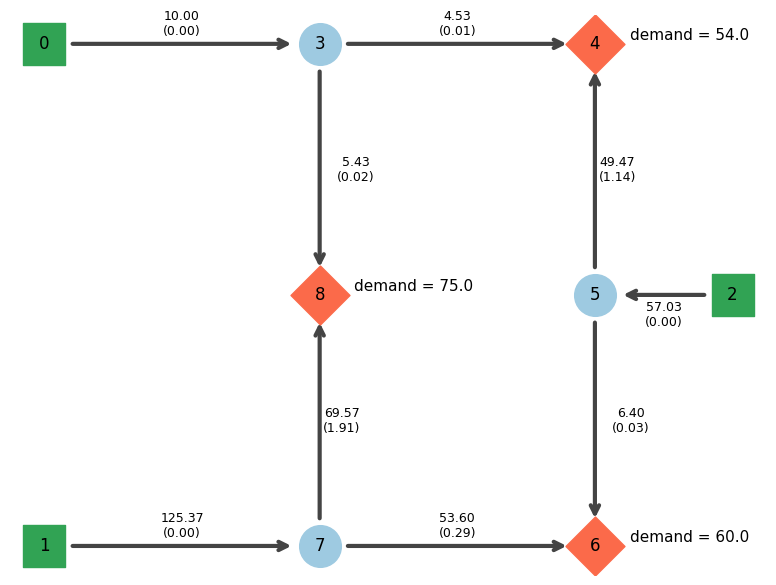

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

# --- Flows: assume flows are provided in this dictionary (replace with your dict) ---
flows = {
    (0, 3): 10.0,
    (3, 4): 4.534,
    (3, 8): 5.4347,
    (7, 8): 69.57,
    (1, 7): 125.368,
    (5, 4): 49.466,
    (5, 6): 6.398,
    (2, 5): 57.03,
    (7, 6): 53.6,
}


losses = {
    (0, 3): 0.00,
    (3, 4): 0.01,
    (3, 8): 0.02,
    (7, 8): 1.91,
    (1, 7): 0.00,
    (5, 4): 1.14,
    (5, 6): 0.03,
    (2, 5): 0.00,
    (7, 6): 0.29,
}

# Demands at sink nodes
demands = {
    4: 54.0,
    6: 60.0,
    8: 75.0,
}

G = nx.DiGraph()

# node drawing size (points^2 as used by scatter)
node_size = 900

# Add edges
edges = [
    (0, 3),
    (3, 4),

    (3, 8),
    (7, 8),
    (1, 7),

    (5, 4),
    (5, 6),
    (2, 5),
    (7, 6),
]

G.add_edges_from(edges)

# Manual layout (x, y)
pos = {
    0: (0, 0),
    3: (2, 0),
    4: (4, 0),

    8: (2, -1.5),
    7: (2, -3),
    1: (0, -3),

    5: (4, -1.5),
    6: (4, -3),
    2: (5, -1.5),
}

# Build a list of flow values in the same order as `edges`
flow_values = np.array([flows.get(e, 0.0) for e in edges], dtype=float)
max_flow = flow_values.max() if flow_values.size > 0 else 1.0

# Make all edges the same thickness and color
edge_width = 3

# --- Create figure/axis ---
fig, ax = plt.subplots(figsize=(8, 6))

# Draw nodes with shapes for generator/sink/other
# Generators: nodes 0,1,2 -> squares
gen_nodes = [0, 1, 2]
sink_nodes = [8, 4, 6]
# Other nodes
other_nodes = [n for n in G.nodes() if n not in gen_nodes + sink_nodes]

# Draw other nodes (circles)
# Draw other nodes (circles)
nx.draw_networkx_nodes(
    G, pos, nodelist=other_nodes, node_shape="o", node_color="#9ecae1", node_size=node_size, ax=ax
)
# Draw generator nodes (squares)
# Draw generator nodes (squares)
nx.draw_networkx_nodes(
    G, pos, nodelist=gen_nodes, node_shape="s", node_color="#31a354", node_size=node_size, ax=ax
)
# Draw sink nodes (diamonds)
# Draw sink nodes (diamonds)
nx.draw_networkx_nodes(
    G, pos, nodelist=sink_nodes, node_shape="D", node_color="#fb6a4a", node_size=node_size, ax=ax
)

# Draw labels on top of nodes
nx.draw_networkx_labels(G, pos, ax=ax)

# Annotate sink nodes with demand values (placed to the right of the marker)
for n in sink_nodes:
    if n in demands:
        x, y = pos[n]
        # offset in points: move right and slightly up so it doesn't overlap the node
        ax.annotate(
            f"demand = {demands[n]:.1f}",
            xy=(x, y),
            xytext=(25, 6),
            textcoords="offset points",
            fontsize=11,
            ha="left",
            va="center",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=0.2),
        )

# Draw edges as shortened arrows so they don't underlap node markers.
# We'll shorten each edge by the node marker radius (in display points).
def shorten_point(a, b, offset_pixels):
    """Return a point moved from a towards b by offset_pixels (in display px)."""
    # transform to display (pixel) coords
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    vec = b_disp - a_disp
    dist = np.hypot(vec[0], vec[1])
    if dist == 0:
        return a
    # unit vector
    u = vec / dist
    new_a_disp = a_disp + u * offset_pixels
    # back to data coords
    return ax.transData.inverted().transform(new_a_disp)

# compute node radius in display pixels from node_size (points^2)
# approximate marker radius in points = sqrt(s) / 2
radius_pts = np.sqrt(node_size) / 2.0
radius_pixels = radius_pts * (fig.dpi / 72.0)

for (u, v) in edges:
    start = np.array(pos[u])
    end = np.array(pos[v])
    # shorten start and end by radius_pixels so arrows stop at node edge
    new_start = shorten_point(start, end, radius_pixels)
    new_end = shorten_point(end, start, radius_pixels)
    arrow = FancyArrowPatch(
        posA=new_start,
        posB=new_end,
        arrowstyle="->",
        mutation_scale=15,
        linewidth=edge_width,
        color="#444444",
        zorder=1,
    )
    ax.add_patch(arrow)

# Add numeric flow labels at the midpoint of each edge with a small perpendicular offset
for (u, v), f in zip(edges, flow_values):
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    mx, my = (x1 + x2) / 2.0, (y1 + y2) / 2.0
    dx, dy = x2 - x1, y2 - y1
    length = np.hypot(dx, dy)
    if length == 0:
        offx, offy = 0.0, 0.0
    else:
        # perpendicular unit vector
        ux, uy = -dy / length, dx / length
        # offset magnitude (tune as needed)
        offset = 0.12
        offx, offy = ux * offset, uy * offset

    # loss: either provided in `losses` dict or compute default I^2R-style loss
    if (u, v) in losses:
        loss = losses[(u, v)]
    else:
        # default: small coefficient * flow^2 (tweak coefficient to match units)
        loss = 0.005 * (f ** 2)

    label = f"{f:.2f}\n({loss:.2f})"

    # For certain vertical branches, move the text 0.5 cm to the right.
    # 0.5 cm ≈ 14 points (1 point = 1/72 inch, 1 cm = 28.3464567 points)
    vertical_branches = {(3, 8), (5, 4), (5, 6), (7, 8)}
    if (u, v) in vertical_branches:
        x_offset_pts = 14  # shift right by ~0.5 cm
        if (u, v) == (7, 8) or (u, v) == (5, 4): 
            x_offset_pts *= 2 
    else:
        x_offset_pts = 0

    # Use annotate: place text at data coords (mx+offx, my+offy) and apply an
    # additional offset in points to the right for the specified branches.
    ax.annotate(
        label,
        xy=(mx + offx, my + offy),
        xytext=(x_offset_pts, 0),
        xycoords="data",
        textcoords="offset points",
        fontsize=9,
        ha="center",
        va="center",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=0.3),
    )

# No colorbar: edges are drawn with a single color now

ax.set_axis_off()

# Save output image so running non-interactively still produces a viewable file
out_file = "power_flow.pdf"
fig.tight_layout()
fig.savefig(out_file, dpi=150)
print(f"Saved plot to {out_file}")